# 基于随机森林算法实现电信用户流失预测任务

# 1.案例概述

**任务描述**：随着电信行业的不断发展，运营商们越来越重视如何扩大其客户群体。据研究，获取新客户所需的成本远高于保留现有客户的成本，因此为了满足在激烈竞争中的优势，保留现有客户成为一大挑战。对电信行业而言，可以通过数据挖掘等方式来分析可能影响客户决策的各种因素，以预测他们是否会产生流失（停用服务、转投其他运营商等）

**数据集**：一共7043条用户样本，每条样本包含21列属性，由多个维度的客户信息以及用户是否最终流失的标签组成，客户信息具体如下：
基本信息：包括性别、年龄、经济情况、入网时间等；
开通业务信息：包括是否开通电话业务、互联网业务、网络电视业务、技术支持业务等；
签署的合约信息：包括合同年限、付款方式、每月费用、总费用等。

**方法概述**：电信用户流失预测中，运营商最为关心的是客户的召回率，即在真正流失的样本中，我们预测到多少条样本。其策略是宁可把未流失的客户预测为流失客户而进行多余的留客行为，也不漏掉任何一名真正流失的客户。预测的主要步骤主要有：数据预处理、可视化分析、特征工程、模型预测、模型评估、分析与决策。

# 2.数据读取

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #  忽略弹出的warnings信息
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]  # matplot中正常显示中文


Bad key "text.kerning_factor" on line 4 in
/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
data = pd.read_csv('Telco-Customer-Churn.csv')
# 显示所以列
pd.set_option('display.max_columns',None)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


21列原始属性中，除了最后一列Churn表示该数据集的目标变量（即标签列）外，其余20列按照原始数据集中的排列顺序刚好可以分为三类特征群：即客户的基本信息、开通业务信息、签署的合约信息。

# 3.数据预处理

查看是否有重复值，有则去重

In [4]:
dupNum = data.shape[0] - data.drop_duplicates().shape[0]
dupNum

0

无重复值，无需处理

## 3.1 缺失值处理

In [5]:
# 缺失值情况
data.isnull().any()

customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

统计结果虽然没有缺失值，但仔细观察会发现 TotalCharges 中，存在如下所示的11条样本，其特征值为空格字符（' '）：

In [6]:
# 查看TotalCharges的缺失值
data[data['TotalCharges']==' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [7]:
# 入网时间为0的客户
data[data['tenure']== 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


进一步观察缺失样本中的tenure（客户入网时间），发现都为0，并且tenure为0与TotalCharges为缺失值一一对应。说明这些客户入网当月就流失了，但仍需收取当月费用。

故总费用TotalCharges即为该用户的每月费用。

In [8]:
#  convert_numeric如果为True，则尝试强制转换为数字，不可转换的变为NaN
data['TotalCharges'] = data['TotalCharges'].apply(pd.to_numeric, errors='coerce') 
# 用MonthlyCharges的数值填充TotalCharges的缺失值
data['TotalCharges'] = data['TotalCharges'].fillna(data['MonthlyCharges'])    
data[data['tenure'] == 0][['MonthlyCharges', 'TotalCharges']]    # 观察处理后缺失值变化情况

,MonthlyCharges,TotalCharges
488,52.55,52.55
753,20.25,20.25
936,80.85,80.85
1082,25.75,25.75
1340,56.05,56.05
3331,19.85,19.85
3826,25.35,25.35
4380,20.00,20.00
5218,19.70,19.70
6670,73.35,73.35


## 3.2 异常值处理

In [9]:
# 查看数值类特征的统计信息：
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.798992
std,0.368612,24.559481,30.090047,2266.730170
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


数据集中大部分为类别特征，并且上表中SeniorCitizen的取值只有0和1，也为类别特征。

剩下的tenure、MonthlyCharges、TotalCharges为数值特征，结合箱体图进行分析：

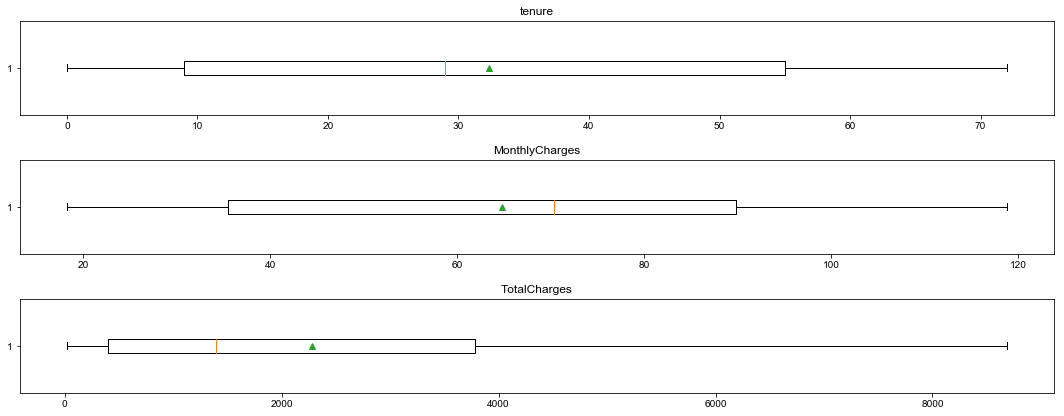

In [10]:
# 箱型图观察异常值情况
import seaborn as sns

#分析百分比特征
fig = plt.figure(figsize=(15,6)) # 建立图像

#tenure
ax1 = fig.add_subplot(311)
list1 = list(data['tenure'])
ax1.boxplot(list1,vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('tenure')

#MonthlyCharges
ax1 = fig.add_subplot(312)
list2 = list(data['MonthlyCharges'])
ax1.boxplot(list2,vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('MonthlyCharges')

#TotalCharges
ax1 = fig.add_subplot(313)
list3 = list(data['TotalCharges'])
ax1.boxplot(list3,vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
ax1.set_title('TotalCharges')

plt.tight_layout(pad=1.5)
plt.show()

由箱型图直观可见，这三列数值特征均不含离群点（即异常值）。同时，其他类别特征的取值也未见异常，因此不需要进行异常值处理。

# 4.可视化分析

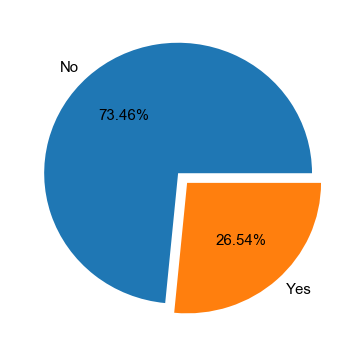

In [11]:
# 观察是否存在类别不平衡现象
p = data['Churn'].value_counts()    # 目标变量正负样本的分布

plt.figure(figsize=(6,6))
# 绘制饼状图并调整字体大小
patches, l_text, p_text = plt.pie(p,labels=['No','Yes'], autopct='%1.2f%%',explode=(0,0.1))
# l_text是饼图外着文字大小，p_text是饼图内文字大小
for t in p_text:
    t.set_size(15)
for t in l_text:
    t.set_size(15)
plt.show()

由饼状图可见流失用户占比为26.54%，存在类别不平衡现象，后续需要进行相应处理。

## 4.2 基本特征对于客户流失影响

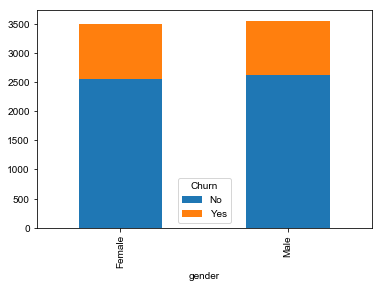

Female流失比例:26.92%
Male流失比例:26.16%


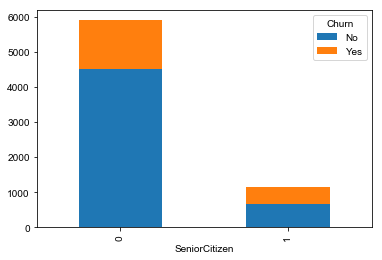

0流失比例:23.61%
1流失比例:41.68%


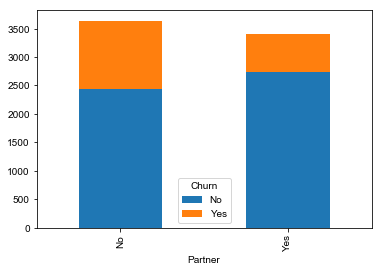

No流失比例:32.96%
Yes流失比例:19.66%


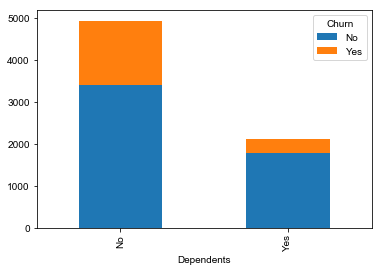

No流失比例:31.28%
Yes流失比例:15.45%


In [12]:
# 性别、是否老年人、是否有配偶、是否有家属等特征对客户流失的影响
baseCols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
for i in baseCols:
    # 构建特征与目标变量的列联表
    cnt = pd.crosstab(data[i],data['Churn'])
    # 绘制堆叠条形图，便于观察不同特征值流失的占比情况
    cnt.plot.bar(stacked=True)
    plt.show()
    print(str(cnt.index[0])+'流失比例:{}%'.format(round(cnt.values[0][1]/cnt.values[0].sum()*100, 2)))
    print(str(cnt.index[1])+'流失比例:{}%'.format(round(cnt.values[1][1]/cnt.values[1].sum()*100, 2)))

由图可知：性别对于客户流失基本无影响；年龄上，老年人流失率更高；婚姻上，无配偶流失率更高；家庭成员上，无家属流失占比更高。

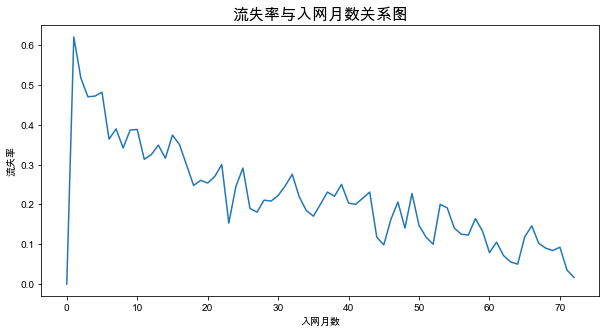

In [13]:
### 观察流失率与入网月数的关系
groupDf = data[['tenure','Churn']]
groupDf['Churn'] = groupDf['Churn'].map({'Yes':1,'No':0}) # 将正负样本目标变量改为1和0方便计算
# 计算不同入网月数对应的流失率  (各入网时间中流失的客户数量/各入网时间客户的总数量)
pctDf = groupDf.groupby('tenure').sum() / groupDf.groupby('tenure').count()
pctDf = pctDf.reset_index() # 将索引变成列,作为绘图的x坐标

#绘制曲线
plt.figure(figsize=(10,5))
plt.title('流失率与入网月数关系图',fontsize=16)
plt.xlabel('入网月数')
plt.ylabel('流失率')
plt.plot(pctDf['tenure'],pctDf['Churn'])
plt.show()

由图可知：除了刚入网（tenure=0）的客户之外，流失率随着入网时间的延长呈下降趋势；当入网超过两个月时，流失率小于留存率，这段时间可以看做客户的适应期。

## 4.3 业务特征对客户流失影响

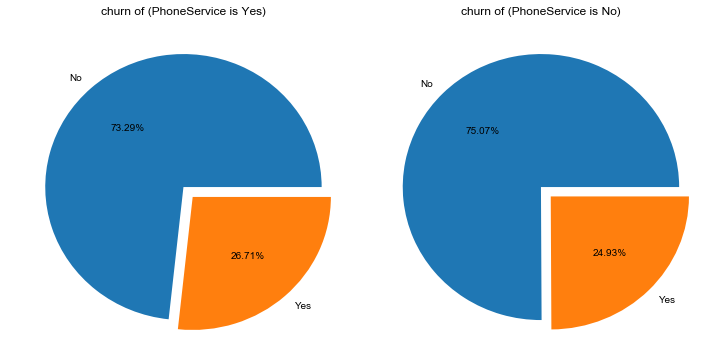

In [14]:
# 电话业务
posDf = data[data['PhoneService'] == 'Yes']
negDf = data[data['PhoneService'] == 'No']

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
p1 = posDf['Churn'].value_counts()
ax1.pie(p1,labels = ['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax1.set_title('churn of (PhoneService is Yes)')

ax2 = fig.add_subplot(122)
p2 = negDf['Churn'].value_counts()
ax2.pie(p2,labels = ['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax2.set_title('churn of (PhoneService is No)')

plt.tight_layout(pad=0.5)
plt.show()

由此可见，电话业务PhoneService是否开通对于客户流失影响很小

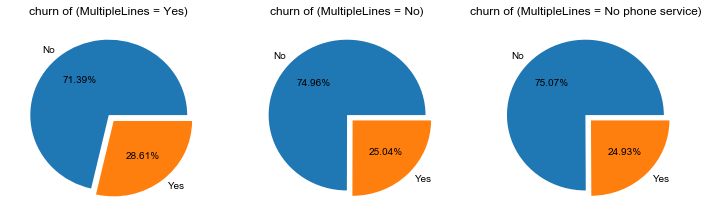

In [15]:
# 多线业务
df1 = data[data['MultipleLines'] == 'Yes']
df2 = data[data['MultipleLines'] == 'No']
df3 = data[data['MultipleLines'] == 'No phone service']

fig = plt.figure(figsize=(10,3))

ax1 = fig.add_subplot(131)
p1 = df1['Churn'].value_counts()
ax1.pie(p1,labels = ['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax1.set_title('churn of (MultipleLines = Yes)')

ax2 = fig.add_subplot(132)
p2 = df2['Churn'].value_counts()
ax2.pie(p2,labels = ['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax2.set_title('churn of (MultipleLines = No)')

ax3 = fig.add_subplot(133)
p3 = df3['Churn'].value_counts()
ax3.pie(p3,labels = ['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax3.set_title('churn of (MultipleLines = No phone service)')

plt.tight_layout(pad=0.5)
plt.show()

由图可知，是否开通多线业务对客户流失影响很小。此外 MultipleLines 取值为 'No'和 'No phone service' 的两种情况基本一致，后续可以合并在一起。

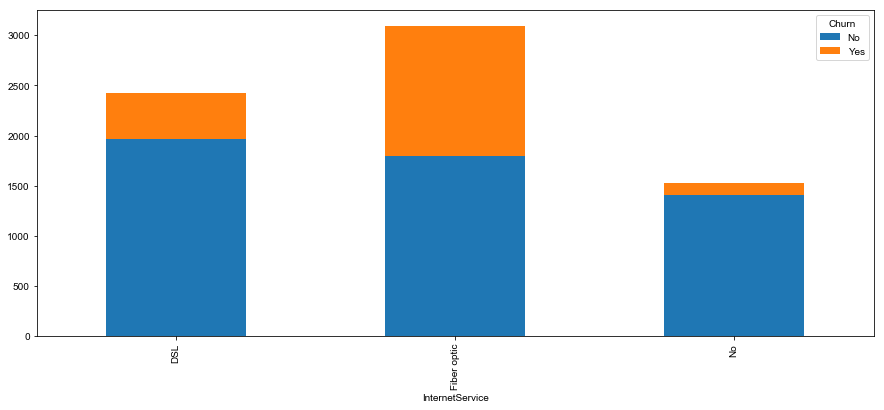

DSL  流失率： 18.96 %
Fiber optic  流失率： 41.89 %
No  流失率： 7.4 %


In [16]:
# 互联网业务
cnt = pd.crosstab(data['InternetService'],data['Churn']) # 构建交叉表
cnt.plot.bar(stacked=True, figsize=(15,6))
plt.show()
print(cnt.index[0],' 流失率：',round(cnt.values[0][1] / cnt.values[0].sum() * 100 , 2),'%')
print(cnt.index[1],' 流失率：',round(cnt.values[1][1] / cnt.values[1].sum() * 100  , 2),'%')
print(cnt.index[2],' 流失率：',round(cnt.values[2][1] / cnt.values[2].sum() * 100  , 2),'%')

由图可知，未开通互联网的客户总数最少，而流失比例最低（7.40%）；开通光纤网络的客户总数最多，流失比例也最高（41.89%）；开通数字网络的客户则均居中（18.96%）。可以推测应该有更深层次的因素导致光纤用户流失更多客户，下一步观察与互联网相关的各项业务。

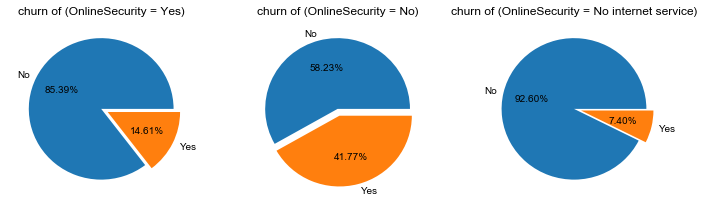

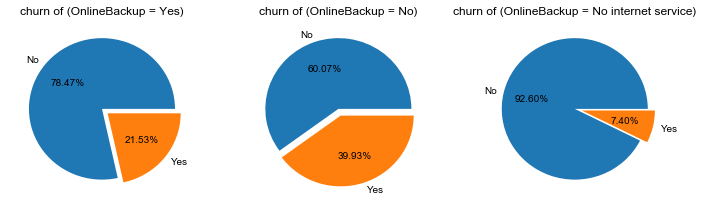

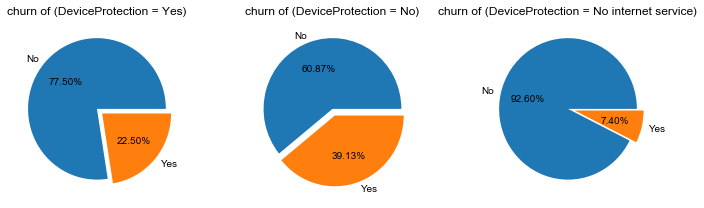

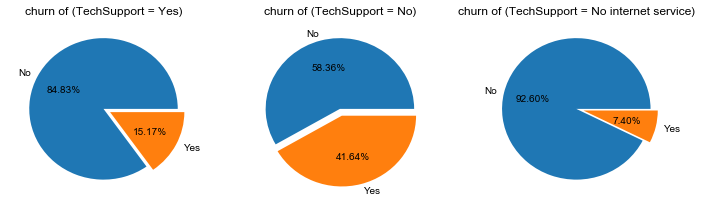

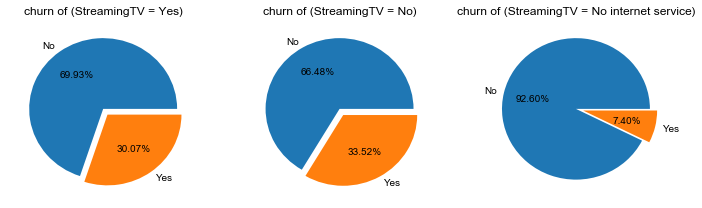

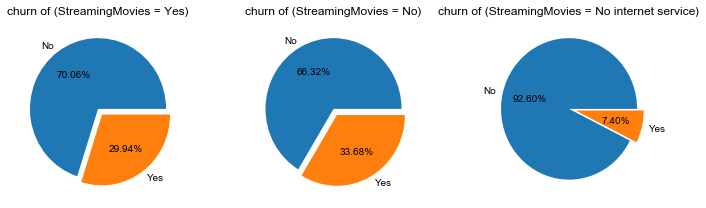

In [17]:
# 与互联网相关的业务
internetCols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for i in internetCols:
    df1 = data[data[i] == 'Yes']
    df2 = data[data[i] == 'No']
    df3 = data[data[i] == 'No internet service']

    fig = plt.figure(figsize=(10,3))

    ax1 = fig.add_subplot(131)
    p1 = df1['Churn'].value_counts()
    ax1.pie(p1,labels = ['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
    ax1.set_title('churn of ({} = Yes)'.format(i))

    ax2 = fig.add_subplot(132)
    p2 = df2['Churn'].value_counts()
    ax2.pie(p2,labels = ['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
    ax2.set_title('churn of ({} = No)'.format(i))

    ax3 = fig.add_subplot(133)
    p3 = df3['Churn'].value_counts()
    ax3.pie(p3,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
    ax3.set_title('churn of ({} = No internet service)'.format(i))

    plt.tight_layout()
    plt.show() 

由图可知：所有互联网相关业务中未开通互联网的客户流失率均为7.40%，可以判断原因是上述六列特征均只在客户开通互联网业务之后才有实际意义，因而不会影响未开通互联网的客户；开通了这些新业务之后，用户的流失率会有不同程度的降低，可以认为多绑定业务有助于用户的留存；'StreamingTV'和 'StreamingMovies'两列特征对客户流失基本没有影响。此外，由于 'No internet service' 也算是 'No' 的一种情况，因此后续步骤中可以考虑将两种特征值进行合并。
 

## 4.4合约特征对客户流失影响 

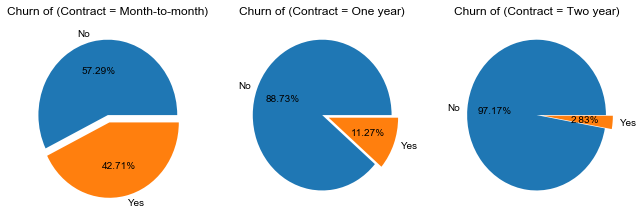

In [18]:
# 合约期限
df1 = data[data['Contract'] == 'Month-to-month']
df2 = data[data['Contract'] == 'One year']
df3 = data[data['Contract'] == 'Two year']

fig = plt.figure(figsize=(9,3))

ax1 = fig.add_subplot(1,3,1)
p1 = df1['Churn'].value_counts()
ax1.pie(p1,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax1.set_title('Churn of (Contract = Month-to-month)')

ax2 = fig.add_subplot(1,3,2)
p2 = df2['Churn'].value_counts()
ax2.pie(p2,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax2.set_title('Churn of (Contract = One year)')

ax3 = fig.add_subplot(1,3,3)
p3 = df3['Churn'].value_counts()
ax3.pie(p3,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax3.set_title('Churn of (Contract = Two year)')

plt.tight_layout(pad=0.5)
plt.show()

由图可知：合约期限越长，用户的流失率越低。

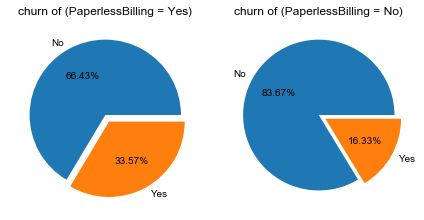

In [19]:
# 是否采用电子结算
df1 = data[data['PaperlessBilling'] == 'Yes']
df2 = data[data['PaperlessBilling'] == 'No']

fig = plt.figure(figsize=(6,3))

ax1 = fig.add_subplot(121)
p1 = df1['Churn'].value_counts()
ax1.pie(p1,labels=['No','Yes'], autopct='%1.2f%%', explode=(0,0.1))
ax1.set_title('churn of (PaperlessBilling = Yes)')

ax2 = fig.add_subplot(122)
p2 = df2['Churn'].value_counts()
ax2.pie(p2,labels=['No','Yes'], autopct='%1.2f%%', explode=(0,0.1))
ax2.set_title('churn of (PaperlessBilling = No)')

plt.tight_layout(pad=0.5)
plt.show()

由图可知，采用电子结算的客户流失率较高，原因可能是电子结算多为按月支付的形式。

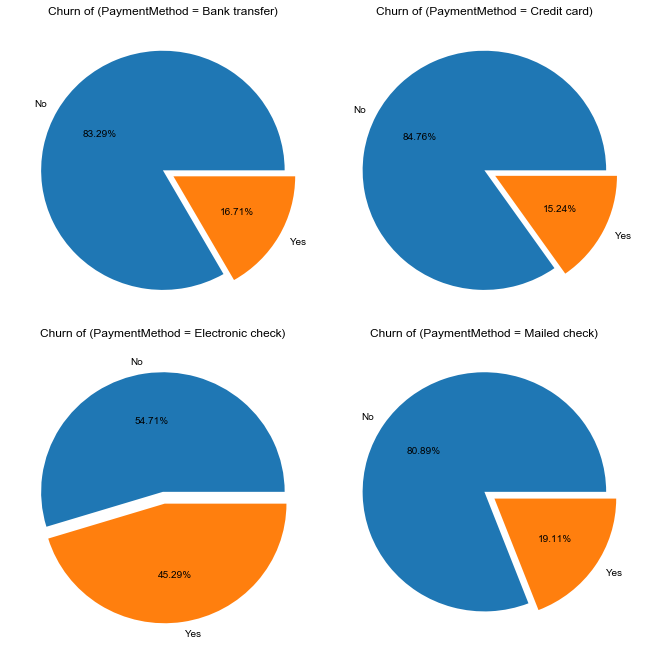

In [20]:
# 付款方式
df1 = data[data['PaymentMethod'] == 'Bank transfer (automatic)']    # 银行转账（自动）
df2 = data[data['PaymentMethod'] == 'Credit card (automatic)']    # 信用卡（自动）
df3 = data[data['PaymentMethod'] == 'Electronic check']    # 电子支票
df4 = data[data['PaymentMethod'] == 'Mailed check']    # 邮寄支票

fig = plt.figure(figsize=(9,9)) # 建立图像

ax1 = fig.add_subplot(221)
p1 = df1['Churn'].value_counts()
ax1.pie(p1,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax1.set_title('Churn of (PaymentMethod = Bank transfer)')

ax2 = fig.add_subplot(222)
p2 = df2['Churn'].value_counts()
ax2.pie(p2,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax2.set_title('Churn of (PaymentMethod = Credit card)')

ax3 = fig.add_subplot(223)
p3 = df3['Churn'].value_counts()
ax3.pie(p3,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax3.set_title('Churn of (PaymentMethod = Electronic check)')

ax4 = fig.add_subplot(224)
p4 = df4['Churn'].value_counts()
ax4.pie(p4,labels=['No','Yes'],autopct='%1.2f%%',explode=(0,0.1))
ax4.set_title('Churn of (PaymentMethod = Mailed check)')

plt.tight_layout(pad=0.5)    # 设置子图之间的间距
plt.show() # 展示饼状图

由图可知：四种付款方式中采用电子支票的客户流失率远高于其他三种。

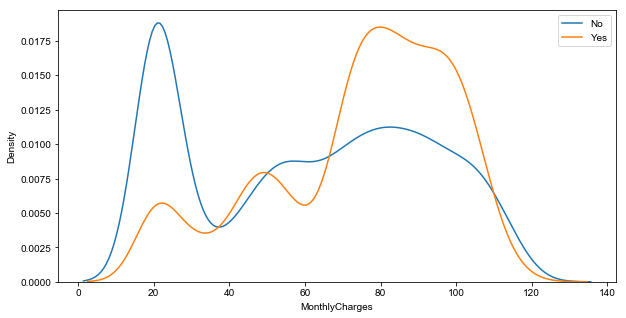

In [21]:
# 每月费用核密度估计图
negDf = data[data['Churn']=='No']
posDf = data[data['Churn']=='Yes']

plt.figure(figsize=(10,5))
sns.distplot(negDf['MonthlyCharges'],hist=False,label='No')
sns.distplot(posDf['MonthlyCharges'],hist=False,label='Yes')
plt.legend()
plt.show()

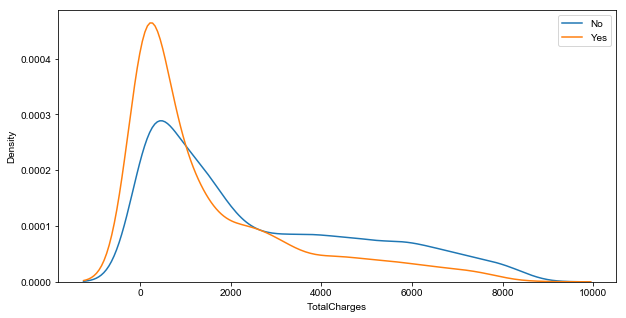

In [22]:
# 总费用核密度估计图
negDf = data[data['Churn']=='No']
posDf = data[data['Churn']=='Yes']

plt.figure(figsize=(10,5))
sns.distplot(negDf['TotalCharges'], hist=False, label='No')
sns.distplot(posDf['TotalCharges'], hist=False, label='Yes')
plt.legend()
plt.show()

由图可知：客户的流失率的基本趋势是随每月费用的增加而增长，这与实际业务较为符合；当客户的总费用积累越多，流失率越低，这说明这些客户已经称为稳定的客户，不会轻易流失；此外，当每月费用处于70～110之间时流失率较高。
 

# 5.特征工程

## 5.1 特征提取

### 数值类特征标准化

In [23]:
import sklearn.preprocessing as sp
data['tenure'] = sp.scale(data['tenure'])
data['MonthlyCharges'] = sp.scale(data['MonthlyCharges'])
data['TotalCharges'] = sp.scale(data['TotalCharges'])
data[['tenure', 'MonthlyCharges', 'TotalCharges']].head()

,tenure,MonthlyCharges,TotalCharges
0,-1.277445,-1.160323,-0.992667
1,0.066327,-0.259629,-0.172198
2,-1.236724,-0.362660,-0.958122
3,0.514251,-0.746535,-0.193706
4,-1.236724,0.197365,-0.938930


将数值特征缩放到同一尺度下，避免对特征重要性产生误判。

### 类别特征编码

In [24]:
# 首先将部分特征值进行合并
data.loc[data['MultipleLines'] == 'No phone service','MultipleLines'] = 'No'

internetCols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for i in internetCols:
    data.loc[data[i]=='No internet service', i] = 'No'

In [25]:
# 部分类别特征只有两类取值，可以直接用0、1代替；另外，可视化过程中发现有四列特征对结果影响可以忽略，后续直接删除
# 选择特征值为‘Yes’和 'No' 的列名
encodeCols = list(data.columns[3: 17].drop(['tenure', 'PhoneService', 'InternetService', 'StreamingTV', 'StreamingMovies', 'Contract']))     
for i in encodeCols:
    data[i] = data[i].map({'Yes': 1, 'No': 0})    # 用1代替'Yes’，0代替 'No'
# 顺便把目标变量也进行编码    
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

In [26]:
# 其他无序的类别特征采用独热编码    
onehotCols = ['InternetService', 'Contract', 'PaymentMethod']
churnDf = data['Churn'].to_frame()    # 取出目标变量列，以便后续进行合并
featureDf = data.drop(['Churn'], axis=1)    # 所有特征列

for i in onehotCols:
    onehotDf = pd.get_dummies(featureDf[i],prefix=i) 
    featureDf = pd.concat([featureDf, onehotDf],axis=1)    # 编码后特征拼接到去除目标变量的数据集中

data = pd.concat([featureDf, churnDf],axis=1)    # 拼回目标变量，确保目标变量在最后一列
data = data.drop(onehotCols, axis=1)    # 删除原特征列
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,7590-VHVEG,Female,0,1,0,-1.277445,No,0,0,1,0,0,No,No,1,-1.160323,-0.992667,1,0,0,1,0,0,0,0,1,0,0
1,5575-GNVDE,Male,0,0,0,0.066327,Yes,0,1,0,1,0,No,No,0,-0.259629,-0.172198,1,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,Male,0,0,0,-1.236724,Yes,0,1,1,0,0,No,No,1,-0.362660,-0.958122,1,0,0,1,0,0,0,0,0,1,1
3,7795-CFOCW,Male,0,0,0,0.514251,No,0,1,0,1,1,No,No,0,-0.746535,-0.193706,1,0,0,0,1,0,1,0,0,0,0
4,9237-HQITU,Female,0,0,0,-1.236724,Yes,0,0,0,0,0,No,No,1,0.197365,-0.938930,0,1,0,1,0,0,0,0,1,0,1


## 5.2 特征选择

'customerID'特征的每个特征值都不同，因此对模型预测不起贡献，可以直接删除。 'gender'、'PhoneService'、'StreamingTV' 和 'StreamingMovies' 则在可视化环节中较为明显地观察到其对目标变量的影响较小，因此也删去这四列特征。

In [27]:
# 删去无用特征 'customerID'、'gender'、 'PhoneService'、'StreamingTV'和'StreamingMovies'
data = data.drop(['customerID','gender', 'PhoneService','StreamingTV','StreamingMovies'],axis=1)
data.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,0,-1.277445,0,0,1,0,0,1,-1.160323,-0.992667,1,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0.066327,0,1,0,1,0,0,-0.259629,-0.172198,1,0,0,0,1,0,0,0,0,1,0
2,0,0,0,-1.236724,0,1,1,0,0,1,-0.362660,-0.958122,1,0,0,1,0,0,0,0,0,1,1
3,0,0,0,0.514251,0,1,0,1,1,0,-0.746535,-0.193706,1,0,0,0,1,0,1,0,0,0,0
4,0,0,0,-1.236724,0,0,0,0,0,1,0.197365,-0.938930,0,1,0,1,0,0,0,0,1,0,1


计算连续型数值特征 'tenure', 'MonthlyCharges', 'TotalCharges' 相关系数，其中 'TotalCharges' 与其他两列特征的相关系数均大于0.6，即存在较强相关性，因此可以考虑删除该列，以避免特征冗余。

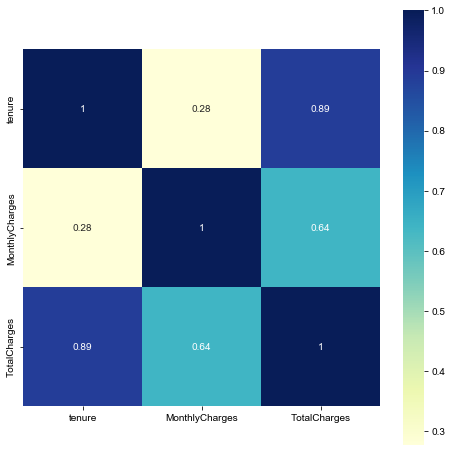

In [28]:
nu_fea = data[['tenure','MonthlyCharges','TotalCharges']]   # 选择连续型数值特征计算相关系数
nu_fea = list(nu_fea)
pearson_mat = data[nu_fea].corr(method='spearman')  # 计算皮尔逊相关系数矩阵

# 用热度图表示相关系数矩阵
plt.figure(figsize=(8,8))
sns.heatmap(pearson_mat,square=True, annot=True, cmap='YlGnBu')
plt.show()

In [29]:
# 删除 TotalCharges
data = data.drop(['TotalCharges'],axis=1)
data.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,MonthlyCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,0,-1.277445,0,0,1,0,0,1,-1.160323,1,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0.066327,0,1,0,1,0,0,-0.259629,1,0,0,0,1,0,0,0,0,1,0
2,0,0,0,-1.236724,0,1,1,0,0,1,-0.362660,1,0,0,1,0,0,0,0,0,1,1
3,0,0,0,0.514251,0,1,0,1,1,0,-0.746535,1,0,0,0,1,0,1,0,0,0,0
4,0,0,0,-1.236724,0,0,0,0,0,1,0.197365,0,1,0,1,0,0,0,0,1,0,1


# 6. 模型预测

## 6.1 类别不平衡处理

在可视化环节中，我们观察到正负样本的比例大概在1:3左右，因此需要对正样本进行升采样或对负样本进行降采样。考虑到本数据集仅有7千多条样本，不适合采用降采样，进行升采样更为合理，本案例采用升采样中较为成熟的SMOTE方法生成更多的正样本。

In [31]:
# SMOTE方法代码
import random
from sklearn.neighbors import NearestNeighbors

class Smote:
    def __init__(self,samples,N,k):
        self.n_samples,self.n_attrs=samples.shape
        self.N=N
        self.k=k
        self.samples=samples
        self.newindex=0

    def over_sampling(self):
        N=int(self.N)
        self.synthetic = np.zeros((self.n_samples * N, self.n_attrs))
        neighbors=NearestNeighbors(n_neighbors=self.k).fit(self.samples)    # 1.对每个少数类样本均求其在所有少数类样本中的k近邻
        for i in range(len(self.samples)):
            nnarray=neighbors.kneighbors(self.samples[i].reshape(1,-1),return_distance=False)[0]
            self._populate(N,i,nnarray)
        return self.synthetic

    # 2.为每个少数类样本选择k个最近邻中的N个；3.并生成N个合成样本
    def _populate(self,N,i,nnarray):
        for j in range(N):
            nn=random.randint(0,self.k-1)
            dif=self.samples[nnarray[nn]]-self.samples[i]
            gap=random.random()
            self.synthetic[self.newindex]=self.samples[i]+gap*dif
            self.newindex+=1    

In [34]:
# 每个正样本用SMOTE方法随机生成两个新的样本
posDf = data[data['Churn'] == 1].drop(['Churn'], axis=1)# 共1869条正样本, 取其所有特征列
posArray = posDf.values  # pd.DataFrame -> np.array, 以满足SMOTE方法的输入要求
newPosArray = Smote(posArray,2,5).over_sampling()
newPosDf = pd.DataFrame(newPosArray)
newPosDf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.0,-1.120098,0.0,0.045304,1.0,0.0,0.0,1.0,-0.453091,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,-1.236724,0.0,1.000000,1.0,0.0,0.0,1.0,-0.362660,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,-1.269067,0.0,0.000000,0.0,0.0,0.0,1.0,0.186806,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,-1.274177,0.0,0.000000,0.0,0.0,0.0,1.0,0.185138,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,-1.018984,1.0,0.000000,0.0,1.0,0.0,1.0,1.165693,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [35]:
# 调整为正样本在数据集中应有的格式
newPosDf.columns = posDf.columns # 还原列名
# 将离散特征列的值变回0，1二元数值
cateCols = list(newPosDf.columns.drop(['tenure', 'MonthlyCharges']))
for i in cateCols:
    newPosDf[i] = newPosDf[i].apply(lambda x:1 if x>=0.5 else 0)
# 添加目标变量列
newPosDf['Churn'] = 1
newPosDf.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,MonthlyCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,0,0,-1.120098,0,0,1,0,0,1,-0.453091,1,0,0,1,0,0,0,0,0,1,1
1,0,0,0,-1.236724,0,1,1,0,0,1,-0.362660,1,0,0,1,0,0,0,0,0,1,1
2,0,0,0,-1.269067,0,0,0,0,0,1,0.186806,0,1,0,1,0,0,0,0,1,0,1
3,0,0,0,-1.274177,0,0,0,0,0,1,0.185138,0,1,0,1,0,0,0,0,1,0,1
4,0,0,0,-1.018984,1,0,0,1,0,1,1.165693,0,1,0,1,0,0,0,0,1,0,1


In [36]:
print("原本的正样本有%d条" % posDf.shape[0])
print("原本的负样本有%d条" % (data.shape[0] - posDf.shape[0]))

原本的正样本有1869条
原本的负样本有5174条


为保证正负样本平衡，从新生成的样本中取出（5174 - 1869 = 3305）条样本，并加入原数据集进行shuffle操作。

In [37]:
# 构建类别平衡的数据集
from sklearn.utils import shuffle

newPosDf = newPosDf[:3305]  #取3305条
data = pd.concat([data, newPosDf])  #拼接
data = shuffle(data).reset_index(drop=True) #随机打乱，重置index
data.shape

(10348, 22)

## 6.2 交叉验证

采用逻辑回归、SVM、随机森林、AdaBoost等算法构建模型，从中选择预测效果较好的模型进行最终的预测。

In [56]:
# 模型预测
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression as LR    # 逻辑回归
from sklearn.svm import SVC    # SVM
from sklearn.ensemble import RandomForestClassifier as RF    # 随机森林
from sklearn.ensemble import AdaBoostClassifier as Adaboost    # AdaBoost
from xgboost import XGBClassifier as XGB    # XGBoost

# 创建模型列表, 预测结果列表
model_list = [LR, SVC, RF, Adaboost, XGB]
pred_list = []
# 数据集整理
x = data.iloc[:,:-1]
y = data.iloc[:,-1]
# 交叉验证，获取预测结果
for m in model_list:
    pred = cross_val_predict(m() ,x, y, cv=5)
    pred_list.append(pred)

[16:48:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

## 7.2 模型评估

对于本案例，精确率代表的意义是：在所有我们预测为流失的样本中，真正流失的样本数；召回率代表的意义则是：在真正流失的样本中，我们预测到多少条样本。很明显，召回率是运营商们关心的指标，即宁可把未流失的客户预测为流失客户而进行多余的留客行为，也不漏掉任何一名真正流失的客户。  

本案例依旧采取精确率、召回率以及综合两者的F1值，但关注的重点仍然放在召回率上。

In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score    # 导入精确率、召回率、F1值等评价指标

scoreDf = pd.DataFrame(columns=['LR', 'SVC', 'RandomForest', 'AdaBoost','XGB'])
for i in range(5):
    r = recall_score(y, pred_list[i])
    p = precision_score(y, pred_list[i])
    f1 = f1_score(y, pred_list[i])
    scoreDf.iloc[:, i] = pd.Series([r, p, f1])

scoreDf.index = ['Recall', 'Precision', 'F1-score']
scoreDf

,LR,SVC,RandomForest,AdaBoost,XGB
Recall,0.796096,0.805373,0.866448,0.820642,0.855431
Precision,0.749182,0.743841,0.831109,0.747404,0.811366
F1-score,0.771927,0.773385,0.848410,0.782312,0.832816


由表可知：五种模型中RandomForest的效果最好，可以用RandomForest单模型进行预测，也可以采用召回率最高的RandomForest和XGBoost进行加权平均融合或Stacking融合。本案例选用RandomForest单模型进行演示，该算法还能同时输出特征重要性。

In [66]:
### 特征重要性
clf = RF()
clf.fit(x,y)
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = data.columns.drop(['Churn']),
                                    columns=['importance']).sort_values('importance', ascending=False
                                  )
feature_importances

,importance
MonthlyCharges,0.247616
tenure,0.234115
Contract_Two year,0.079327
Contract_Month-to-month,0.055982
InternetService_Fiber optic,0.042101
PaymentMethod_Electronic check,0.030465
PaperlessBilling,0.028257
InternetService_No,0.028238
Contract_One year,0.027516
Partner,0.026188


# 8.分析与决策

## 8.1 用户画像

### 基于可视化分析，可发现较易流失的客户画像：
1. 基本信息
    - 老年人
    - 未婚
    - 无家属
    - 入网时间短，2个月之内的尤为明显
2. 开通业务
    - 开通光纤网络
    - 未开通在线安全、在线备份、设备保护、技术支持等互联网增值业务
3. 签订合约
    - 合约期限较短，特别是逐月付费客户最易流失
    - 采用电子结算（多为按月支付）
    - 采用电子支票
    - 每月费用较高，特别是70～110之间
    - 总费用较低（侧面反应入网时间较短）
    
### 相应决策：
- 对老人推出亲情套餐等优惠
- 对未婚、无家属的客户推出暖心套餐等优惠
- 对新入网用户提供一定时期的优惠活动，直至客户到达稳定期
- 提高电话服务、光纤网络、网络电视、网络电影等的客户体验，尝试提高用户的留存率，避免客户流失
- 对能够帮助客户留存的在线安全、在线备份、设备保护、技术支持等互联网增值业务，加大宣传推广力度
- 对逐月付费用户推出年费优惠活动
- 对使用电子结算、电子支票的客户，推出其他支付方式的优惠活动
- 对每月费用在70～110之间推出一定的优惠活动
- ...

## 8.2 结合模型

结合预测的概率值对部分客户进行重点留存

In [93]:
# 预测客户流失的概率值
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=0)
y_prob = np.zeros(len(y))  # 初始化预测概率值数组
# 预测概率值
for train_index, test_index in kf.split(x):
    x_train = x.iloc[train_index]
    x_test = x.iloc[test_index]
    y_train = y.iloc[train_index]
    clf = RF()
    clf.fit(x_train,y_train)
    y_prob[test_index] = clf.predict_proba(x_test)[:,1]
prob = np.round(y_prob, 1)   # 对预测出的概率值保留一位小数，便于分组观察

# # 合并预测值和真实值
probDf = pd.DataFrame(prob)
churnDf = pd.DataFrame(y)
df1 = pd.concat([probDf, churnDf], axis=1)
df1.columns = ['prob', 'churn']
df1 = df1[:7043]    # 只取原始数据集的7043条样本进行决策
df1.head()

,prob,churn
0,0.2,0
1,0.0,0
2,0.8,1
3,1.0,1
4,0.0,0


In [94]:
# 分组计算每种预测概率值所对应的真实流失率
group = df1.groupby('prob')
df2 = pd.concat([group.count(), group.sum()/group.count()], axis=1).reset_index()
df2.columns = ['prob', 'churn', 'true_prob']
df2

,prob,churn,true_prob
0,0.0,1289,0.021722
1,0.1,541,0.070240
2,0.2,479,0.125261
3,0.3,379,0.195251
4,0.4,371,0.331536
5,0.5,375,0.402667
6,0.6,388,0.592784
7,0.7,459,0.721133
8,0.8,634,0.817035
9,0.9,781,0.882202


由表可知：预测流失率越大的客户中越有可能真正发生流失。对运营商而言，可以根据各预测概率值分组的真实流失率设定阈值进行决策。例如，假设阈值为true_prob = 0.6，即优先关注真正流失为60%以上的群体，也就表示运营商可以对预测结果中大于等于0.7的客户进行重点留存。
 